# Parameter identification interface
### User-interface to perform parameter identification of bioscrape/SBML models

* Simple functions to import models/data 
* Use the fast deterministic and stochastic simulators available within bioscrape
* (Optionally) Specify paramter priors, desired likelihood/cost functions 
* Create your own likelihood functions interface

## Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples.

In [11]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt

# Import bioscrape XML / bioscrape model object M / SBML file
# M  = bs.types.read_model_from_sbml(filename)
# M = Model('models/pid_model.xml')

# Or...Create a Model using the bioscrape API
species = ['X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), ([], ['X'], 'massaction', {'k':'k1'})]
k1 = 10.0
d1 = .2
params = [('k1', k1), ('d1', d1)]
initial_condition = {'X':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

# Import data from CSV
# data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})

M.py_initialize()

N = 1 #Number of trajectories
nT = 50 #number of timepoints
noise_std = 0.2 #Standar deviation of the guassian noise added onto the measurements

MultipleTimepoints = False #Different timepoints for each trajectory?
timepoint_list = []
# timepoints = np.linspace(np.random.randint(0, 10), np.random.randint(10, 100), nT)
timepoints = np.linspace(0, 100, nT)
#Generate Trajectories
R = [] #Results as Pandas Dataframes
data = [] #Results will become a numpy array
MultipleInitialConditions = False #Different initial conditions for each trajectory?

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {'X': np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = True)
    R.append(r)
    noisy_data = r['X'].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    data.append(noisy_data)

M_original = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
M_original.write_bioscrape_xml('toy_model.xml')


In [48]:
import pandas as pd
# Write noisy data to csv
# df = pd.concat(R)
file_name = 'test_data.csv'
R[0].to_csv(file_name, sep='\t', header = True)

### To run the MCMC algorithm to identify parameters from the data, the following code can be used.

Sample log-like: 366.9203261304787
Sample log-like: 366.9252372448776
Sample log-like: 366.8413759341001
Sample log-like: 366.9403966760396
Sample log-like: 366.95218900571666
Sample log-like: 366.90871745870515
Sample log-like: 366.89626291459894
Sample log-like: 366.9146009659712
Sample log-like: 366.95295310008805
Sample log-like: 367.0082809686252
Sample log-like: 366.90623113481576
Sample log-like: 366.9602960527307
Sample log-like: 366.9799244493942
Sample log-like: 366.9403641130415
Sample log-like: 366.9322220027097
Sample log-like: 366.89566238168936
Sample log-like: 366.76058567235646
Sample log-like: 366.89640904605153
Sample log-like: 366.8936653880573
Sample log-like: 366.96690445258173
Sample log-like: 366.96769260177905
Sample log-like: 366.890802056699
Sample log-like: 366.7985121415762
Sample log-like: 366.88213537481835
Sample log-like: 366.8428717486237
Sample log-like: 366.89648016274407
Sample log-like: 366.82438349706916
Sample log-like: 366.9595317973599
Sample l

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


0.1 percent complete
0.1 percent complete
0.1 percent complete
0.2 percent complete
0.2 percent complete
0.3 percent complete
0.3 percent complete
0.4 percent complete
0.5 percent complete
0.5 percent complete
0.6 percent complete
0.6 percent complete
0.7 percent complete
0.7 percent complete
0.8 percent complete
0.8 percent complete
0.8 percent complete
0.9 percent complete
0.9 percent complete
1.0 percent complete
1.1 percent complete
1.1 percent complete
1.1 percent complete
1.2 percent complete
1.2 percent complete
1.3 percent complete
1.4 percent complete
1.4 percent complete
1.4 percent complete
1.5 percent complete
1.6 percent complete
1.6 percent complete
1.6 percent complete
1.7 percent complete
1.8 percent complete
1.8 percent complete
1.9 percent complete
1.9 percent complete
1.9 percent complete
2.0 percent complete
2.0 percent complete
2.1 percent complete
2.1 percent complete
2.2 percent complete
2.2 percent complete
2.3 percent complete
2.4 percent complete
2.4 percent c

19.2 percent complete
19.3 percent complete
19.4 percent complete
19.4 percent complete
19.4 percent complete
19.5 percent complete
19.6 percent complete
19.6 percent complete
19.6 percent complete
19.7 percent complete
19.8 percent complete
19.8 percent complete
19.9 percent complete
19.9 percent complete
19.9 percent complete
20.0 percent complete
20.1 percent complete
20.1 percent complete
20.1 percent complete
20.2 percent complete
20.2 percent complete
20.3 percent complete
20.4 percent complete
20.4 percent complete
20.4 percent complete
20.5 percent complete
20.6 percent complete
20.6 percent complete
20.6 percent complete
20.7 percent complete
20.8 percent complete
20.8 percent complete
20.9 percent complete
20.9 percent complete
20.9 percent complete
21.0 percent complete
21.1 percent complete
21.1 percent complete
21.1 percent complete
21.2 percent complete
21.2 percent complete
21.3 percent complete
21.4 percent complete
21.4 percent complete
21.4 percent complete
21.5 perce

38.0 percent complete
38.0 percent complete
38.1 percent complete
38.1 percent complete
38.2 percent complete
38.2 percent complete
38.3 percent complete
38.4 percent complete
38.4 percent complete
38.5 percent complete
38.5 percent complete
38.5 percent complete
38.6 percent complete
38.6 percent complete
38.7 percent complete
38.8 percent complete
38.8 percent complete
38.9 percent complete
38.9 percent complete
39.0 percent complete
39.0 percent complete
39.0 percent complete
39.1 percent complete
39.1 percent complete
39.2 percent complete
39.2 percent complete
39.3 percent complete
39.4 percent complete
39.4 percent complete
39.5 percent complete
39.5 percent complete
39.5 percent complete
39.6 percent complete
39.6 percent complete
39.7 percent complete
39.8 percent complete
39.8 percent complete
39.9 percent complete
39.9 percent complete
40.0 percent complete
40.0 percent complete
40.0 percent complete
40.1 percent complete
40.1 percent complete
40.2 percent complete
40.2 perce

56.7 percent complete
56.8 percent complete
56.8 percent complete
56.9 percent complete
56.9 percent complete
57.0 percent complete
57.0 percent complete
57.0 percent complete
57.1 percent complete
57.1 percent complete
57.2 percent complete
57.2 percent complete
57.3 percent complete
57.4 percent complete
57.4 percent complete
57.5 percent complete
57.5 percent complete
57.5 percent complete
57.6 percent complete
57.6 percent complete
57.7 percent complete
57.8 percent complete
57.8 percent complete
57.9 percent complete
57.9 percent complete
58.0 percent complete
58.0 percent complete
58.0 percent complete
58.1 percent complete
58.1 percent complete
58.2 percent complete
58.2 percent complete
58.3 percent complete
58.4 percent complete
58.4 percent complete
58.5 percent complete
58.5 percent complete
58.5 percent complete
58.6 percent complete
58.6 percent complete
58.7 percent complete
58.8 percent complete
58.8 percent complete
58.9 percent complete
58.9 percent complete
59.0 perce

75.5 percent complete
75.5 percent complete
75.5 percent complete
75.6 percent complete
75.7 percent complete
75.7 percent complete
75.8 percent complete
75.8 percent complete
75.8 percent complete
75.9 percent complete
76.0 percent complete
76.0 percent complete
76.0 percent complete
76.1 percent complete
76.2 percent complete
76.2 percent complete
76.2 percent complete
76.3 percent complete
76.3 percent complete
76.4 percent complete
76.5 percent complete
76.5 percent complete
76.5 percent complete
76.6 percent complete
76.7 percent complete
76.7 percent complete
76.8 percent complete
76.8 percent complete
76.8 percent complete
76.9 percent complete
77.0 percent complete
77.0 percent complete
77.0 percent complete
77.1 percent complete
77.2 percent complete
77.2 percent complete
77.2 percent complete
77.3 percent complete
77.3 percent complete
77.4 percent complete
77.5 percent complete
77.5 percent complete
77.5 percent complete
77.6 percent complete
77.7 percent complete
77.7 perce

94.2 percent complete
94.3 percent complete
94.3 percent complete
94.4 percent complete
94.5 percent complete
94.5 percent complete
94.5 percent complete
94.6 percent complete
94.7 percent complete
94.7 percent complete
94.8 percent complete
94.8 percent complete
94.8 percent complete
94.9 percent complete
95.0 percent complete
95.0 percent complete
95.0 percent complete
95.1 percent complete
95.2 percent complete
95.2 percent complete
95.2 percent complete
95.3 percent complete
95.3 percent complete
95.4 percent complete
95.5 percent complete
95.5 percent complete
95.5 percent complete
95.6 percent complete
95.7 percent complete
95.7 percent complete
95.8 percent complete
95.8 percent complete
95.8 percent complete
95.9 percent complete
96.0 percent complete
96.0 percent complete
96.0 percent complete
96.1 percent complete
96.2 percent complete
96.2 percent complete
96.2 percent complete
96.3 percent complete
96.3 percent complete
96.4 percent complete
96.5 percent complete
96.5 perce

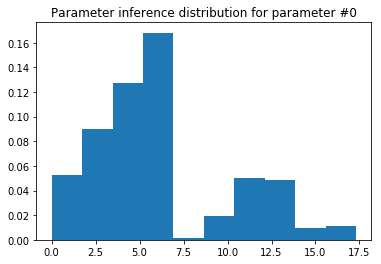

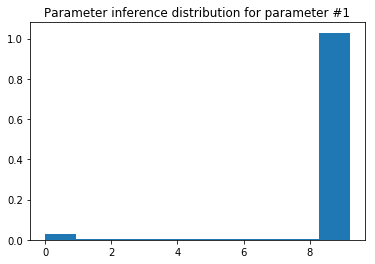

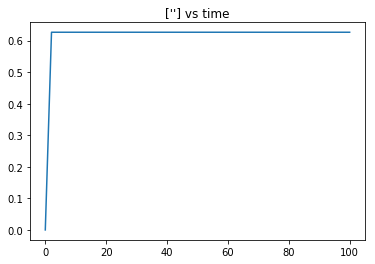

In [13]:
# Run parameter identification procedure using Python emcee -
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *

pid = initialize_mcmc()
pid.exp_data = np.array(data)
pid.M = M
pid.prior = {'k1' : ['uniform', 1e-2, 1e4],'d1' : ['uniform', 1e-3, 1e3]}
pid.params_to_estimate = {'k1':10, 'd1':0.2}
pid.type = 'deterministic'
pid.timepoints = timepoints[0:15]
pid.initial_conditions = initial_condition
pid.nsamples = 500
pid.nsteps = 2000
pid.nwalkers = 200
fitted_model, params = pid.run_mcmc(plot_show = True, progress = False)

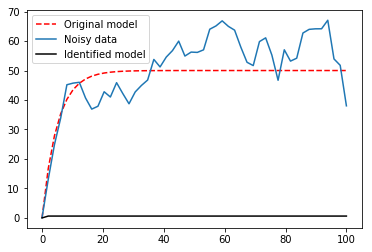

In [14]:
sim_x = py_simulate_model(timepoints, Model = M_original, stochastic = False)
sim_x_inf = py_simulate_model(timepoints, Model = fitted_model, stochastic = False)
plt.plot(timepoints, sim_x['X'], 'r--', label = 'Original model')
plt.plot(timepoints, noisy_data, label = 'Noisy data')
plt.plot(timepoints, sim_x_inf['X'], 'k', label = 'Identified model')

plt.legend()

In [7]:
M.get_parameter_values()

array([1.57056605e-04, 5.24060327e+00])

In [9]:
M.get_species_array()

array([61.])

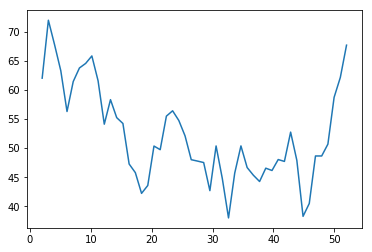

In [12]:
plt.plot(timepoints, noisy_data, label = 'Noisy data')

In [13]:
initial_condition

{'X': 61}

In [31]:
type(R[1])

pandas.core.frame.DataFrame

In [57]:
type(pid.exp_data)

numpy.ndarray

In [7]:
np.shape(initial_condition.keys())

()

In [13]:
len(list(initial_condition.values()))

1

In [15]:
timepoints[0:15]

array([ 0.        ,  2.04081633,  4.08163265,  6.12244898,  8.16326531,
       10.20408163, 12.24489796, 14.28571429, 16.32653061, 18.36734694,
       20.40816327, 22.44897959, 24.48979592, 26.53061224, 28.57142857])